In [26]:
import os
import pandas as pd
import argparse
import warnings
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
import numpy as np
from scipy import stats
from train import train_parameter, test_parameter, train_non_parameter, test_non_parameter
from model_non_parameter import ANN_gaussian, ANN_quantile,DRO_layer_dynamic_price,Intra_schdule_layer,Determinisitic_layer
from model_non_parameter import Combined_model_non_parameter_dynamic_price,Combined_deterministic_non_parameter_dynamic_price
from optimization import SO_cvxpy_parameter,DRO_cvxpy_non_parameter
from test_non_parameter import Evaluation_deterministic_non_parameter,Evaluation_original_model_non_parameter
from online_non_parameter import *
warnings.filterwarnings("ignore")
#torch.set_default_dtype(torch.float64)

In [27]:
set_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='no-parameter')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=5e-3)
parser_train.add_argument('--patience', type=int, default=20)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-5) 
parser_train.add_argument('--ft_lr', type=int, default=1e-3)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])

parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--x_max', type=int, default=3000)
parser_train.add_argument('--x_min', type=int, default=0)
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=1000)
parser_train.add_argument('--r_pos', type=int, default=1000)
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])

parser_train.add_argument('--price_ratio_large', type=float, default=4)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
# True+1：（e2e ft lr：1e-5），（e2e ft: 1e-6）
# True+2: （e2e ft lr：1e-6），（e2e ft: 1e-5）
parser_train.add_argument('--flag_dynamic_price', type=bool, default=True)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=1)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)

args_train = parser_train.parse_args(args=[])

In [29]:
import json
args_dict = vars(args_train)

# 将字典保存为 JSON 文件
with open('./Args/args_non_parameter_small_price_deviation.json', 'w') as f:
    json.dump(args_dict, f, indent=4)

In [30]:
train_load_data,train_load_loader=get_load_data(args_train,flag='train')
val_load_data,val_load_loader=get_load_data(args_train,flag='val')
test_load_data,test_load_loader=get_load_data(args_train,flag='test')

train_pv_data,train_pv_loader=get_pv_data(args_train,flag='train')
val_pv_data,val_pv_loader=get_pv_data(args_train,flag='val')
test_pv_data,test_pv_loader=get_pv_data(args_train,flag='test')

combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args_train,train_pv_data,train_load_data,val_pv_data,val_load_data,test_pv_data,test_load_data)


../Data/GEF_data/data.csv
(143, 24, 11)
(143, 24)
../Data/GEF_data/data.csv
(36, 24, 11)
(36, 24)
../Data/GEF_data/data.csv
(544, 24, 11)
(544, 24)
../Data/PV/PV_1h.csv
(143, 13, 11)
(143, 13)
../Data/PV/PV_1h.csv
(36, 13, 11)
(36, 13)
../Data/PV/PV_1h.csv
(544, 13, 11)
(544, 13)
Test data is not shuffled
Test data is not shuffled


### load forecasting

In [31]:
input_size=train_load_data.X.shape[-1]
output_size=len(args_train.quantiles)
set_seed(42)
model_load=ANN_quantile(input_size=input_size, hidden_layers=args_train.hidden_layers, quantiles=args_train.quantiles).to(device)
train_non_parameter(args_train, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Epoch 0, Train Loss: 0.2653690092265606
Epoch [1/1000] Train Loss: 0.2654 Val Loss: 0.1465
Epoch [2/1000] Train Loss: 0.1326 Val Loss: 0.1187
Epoch [3/1000] Train Loss: 0.0990 Val Loss: 0.0975
Epoch [4/1000] Train Loss: 0.0943 Val Loss: 0.0924
Epoch [5/1000] Train Loss: 0.0874 Val Loss: 0.1060
Epoch [6/1000] Train Loss: 0.0841 Val Loss: 0.0833
Epoch [7/1000] Train Loss: 0.0727 Val Loss: 0.0814
Epoch [8/1000] Train Loss: 0.0692 Val Loss: 0.0784
Epoch [9/1000] Train Loss: 0.0652 Val Loss: 0.0759
Epoch [10/1000] Train Loss: 0.0648 Val Loss: 0.0818
Epoch 10, Train Loss: 0.06325957458466291
Epoch [11/1000] Train Loss: 0.0633 Val Loss: 0.0827


Epoch [12/1000] Train Loss: 0.0651 Val Loss: 0.0793
Epoch [13/1000] Train Loss: 0.0585 Val Loss: 0.0750
Epoch [14/1000] Train Loss: 0.0583 Val Loss: 0.0770
Epoch [15/1000] Train Loss: 0.0568 Val Loss: 0.0752
Epoch [16/1000] Train Loss: 0.0591 Val Loss: 0.0812
Epoch [17/1000] Train Loss: 0.0598 Val Loss: 0.0778
Epoch [18/1000] Train Loss: 0.0607 Val Loss: 0.0788
Epoch [19/1000] Train Loss: 0.0578 Val Loss: 0.0719
Epoch [20/1000] Train Loss: 0.0556 Val Loss: 0.0781
Epoch 20, Train Loss: 0.05533484974876046
Epoch [21/1000] Train Loss: 0.0553 Val Loss: 0.0817
Epoch [22/1000] Train Loss: 0.0526 Val Loss: 0.0744
Epoch [23/1000] Train Loss: 0.0558 Val Loss: 0.0737
Epoch [24/1000] Train Loss: 0.0493 Val Loss: 0.0785
Epoch [25/1000] Train Loss: 0.0463 Val Loss: 0.0711
Epoch [26/1000] Train Loss: 0.0483 Val Loss: 0.0798
Epoch [27/1000] Train Loss: 0.0514 Val Loss: 0.0825
Epoch [28/1000] Train Loss: 0.0483 Val Loss: 0.0786
Epoch [29/1000] Train Loss: 0.0450 Val Loss: 0.0680
Epoch [30/1000] Train 

### pv forecasting

In [32]:
input_size=train_pv_data.X.shape[-1]#pv_flag=False,threshold=10,scaler_y=train_pv_data.scaler_y
model_pv=ANN_quantile(input_size=input_size, hidden_layers=args_train.hidden_layers, quantiles=args_train.quantiles,pv_flag=True,threshold=10,scaler_y=train_pv_data.scaler_y).to(device)
train_non_parameter(args_train, model_pv, train_pv_loader, val_pv_loader,dir_best_model='../Model/best_ann_pv.pt')

Epoch 0, Train Loss: 0.30013379640877247
Epoch [1/1000] Train Loss: 0.3001 Val Loss: 0.1628
Epoch [2/1000] Train Loss: 0.1665 Val Loss: 0.1254
Epoch [3/1000] Train Loss: 0.1357 Val Loss: 0.1251
Epoch [4/1000] Train Loss: 0.1275 Val Loss: 0.1116
Epoch [5/1000] Train Loss: 0.1160 Val Loss: 0.1160
Epoch [6/1000] Train Loss: 0.1136 Val Loss: 0.1053
Epoch [7/1000] Train Loss: 0.1062 Val Loss: 0.1087
Epoch [8/1000] Train Loss: 0.1055 Val Loss: 0.1067
Epoch [9/1000] Train Loss: 0.1027 Val Loss: 0.1085
Epoch [10/1000] Train Loss: 0.1044 Val Loss: 0.1041
Epoch 10, Train Loss: 0.10233965702354908
Epoch [11/1000] Train Loss: 0.1023 Val Loss: 0.1007
Epoch [12/1000] Train Loss: 0.1000 Val Loss: 0.1023
Epoch [13/1000] Train Loss: 0.0987 Val Loss: 0.1078
Epoch [14/1000] Train Loss: 0.0984 Val Loss: 0.1022
Epoch [15/1000] Train Loss: 0.0934 Val Loss: 0.1005
Epoch [16/1000] Train Loss: 0.0941 Val Loss: 0.0985
Epoch [17/1000] Train Loss: 0.0900 Val Loss: 0.0992
Epoch [18/1000] Train Loss: 0.0893 Val Los

In [33]:
determinisitic_opt_layer = Determinisitic_layer(args_train)
intra_opt_layer = Intra_schdule_layer(args_train)
dro_opt_layer = DRO_layer_dynamic_price(args_train)

In [34]:
model_org_deterministic =  Combined_deterministic_non_parameter_dynamic_price(determinisitic_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)
model_org_dro =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load)).to(device)

In [35]:
solution_list_org_ahead_deterministic, solution_list_org_intra_deterministic, cost_org_deterministic =Evaluation_original_model_non_parameter(args_train, model_org_deterministic, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y)

In [36]:
solution_list_org_ahead_ideal, solution_list_org_intra_ideal, cost_org_ideal =Evaluation_original_model_non_parameter(args_train, model_org_deterministic, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='ideal')

In [37]:
Opt_layer = DRO_layer_dynamic_price(args_train)
model_org=  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
model_org=model_org.to(device)

In [38]:
solution_list_org_intra_dro, solution_list_org_ahead_dro, cost_org_dro, forecasts_pv_org, forecasts_load_org,targets_pv,targets_load=Evaluation_original_model_non_parameter(args_train, model_org_dro, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y,mode='dro')

--------------PV--------------
Pinball Loss: 48.64499088557934
Winkler Score_0.1: 727.1666915147538
MAE: 126.77077400009632
RMSE: 247.43585484978834
--------------Load--------------
Pinball Loss: 88.74879125354754
Winkler Score_0.1: 1975.1333206803663
MAE: 228.89960058104793
RMSE: 295.34159001259064
--------------PV--------------
Pinball Loss: 45.00709781675071
Winkler Score_0.1: 687.8152537917758
MAE: 117.90819297427004
RMSE: 218.58599147109558
--------------Load--------------
Pinball Loss: 71.93364135055104
Winkler Score_0.1: 1449.3893135004294
MAE: 173.98050508862443
RMSE: 209.94131579063242


--------------PV--------------
Pinball Loss: 43.75547477509531
Winkler Score_0.1: 735.1784810948762
MAE: 109.69079809445321
RMSE: 207.12298666188613
--------------Load--------------
Pinball Loss: 52.415834380437175
Winkler Score_0.1: 1056.0147481585318
MAE: 130.46710206406476
RMSE: 163.419462963863
--------------PV--------------
Pinball Loss: 53.58309916536819
Winkler Score_0.1: 788.2820217768505
MAE: 141.9641649276798
RMSE: 275.77259182306756
--------------Load--------------
Pinball Loss: 59.33264612840847
Winkler Score_0.1: 1343.5772129148504
MAE: 142.4572665135618
RMSE: 190.33603503615055
--------------PV--------------
Pinball Loss: 54.233022424163494
Winkler Score_0.1: 795.4559323296271
MAE: 144.9884113509375
RMSE: 282.97106779965276
--------------Load--------------
Pinball Loss: 44.15043291565298
Winkler Score_0.1: 738.0725775950157
MAE: 116.15035857212474
RMSE: 142.13981067621182
--------------PV--------------
Pinball Loss: 116.48073912450266
Winkler Score_0.1: 2380.653586452379


In [39]:
combined_model =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
combined_model.to(device)
set_seed(42)
solution_list_ahead, solution_list_intra, cost_list, forecasts_pv,forecasts_load = Traditional_online_non_parameter(args_train, combined_model, combined_fine_tune_loader, combined_test_loader,train_pv_data.scaler_y,train_load_data.scaler_y)

New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 48.636334908308555
Winkler Score_0.1: 727.1400110947254
MAE: 126.75567736946769
RMSE: 247.40332426362053
--------------Load--------------
Pinball Loss: 88.32016600859548
Winkler Score_0.1: 1956.4426672783823
MAE: 228.06373588138715
RMSE: 294.02566628780244
Test Objective: 2495.922815262274
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 44.9857732270933
Winkler Score_0.1: 687.6362251687808
MAE: 117.82813057389765
RMSE: 218.51877673324068
--------------Load--------------
Pinball Loss: 72.35942075503534
Winkler Score_0.1: 1460.7544658551622
MAE: 174.98843113903254
RMSE: 210.88186622226368
Test Objective: 2175.241894475026
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 43.727390326367285
Winkler Score_0.1: 735.1305309716528
MAE: 109.61839507748924
RMSE: 206.993456950468
--------------Load--------------
Pinball Loss: 52.168206

In [40]:
combined_model_e2e =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
combined_model_e2e.to(device)
set_seed(42)
solution_list_ahead_e2e, solution_list_intra_e2e,cost_list_e2e, forecasts_pv_e2e,forecasts_load_e2e = E2E_non_parameter(args_train, combined_model_e2e, combined_train_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)
solution_list_ahead_e2e_ecl,solution_list_intra_e2e, cost_list_e2e_ecl, forecasts_pv_e2e_ecl,forecasts_load_e2e_ecl  = E2E_online_non_parameter(args_train, combined_model_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

e2e epoch: 0
e2e epoch: 1
e2e epoch: 2
--------------PV--------------
Pinball Loss: 50.30396256778408
Winkler Score_0.1: 731.498298920872
MAE: 145.27705986318966
RMSE: 273.31495930703505
--------------Load--------------
Pinball Loss: 79.63224131835912
Winkler Score_0.1: 1661.8590869757786
MAE: 189.75109992120142
RMSE: 233.6357565556209
Test Objective: 2521.0478265254446
--------------PV--------------
Pinball Loss: 47.31422531868534
Winkler Score_0.1: 691.6749320320674
MAE: 149.91320778828808
RMSE: 253.06361321726502
--------------Load--------------
Pinball Loss: 78.9770179281824
Winkler Score_0.1: 1635.6055895515303
MAE: 211.16880077703294
RMSE: 248.11654662414838
Test Objective: 2270.4553176562404
--------------PV--------------
Pinball Loss: 45.057300370791154
Winkler Score_0.1: 722.9017108776129
MAE: 131.23561724869697
RMSE: 244.85465987425735
--------------Load--------------
Pinball Loss: 48.44243801579047
Winkler Score_0.1: 912.4712665952989
MAE: 118.05796533844949
RMSE: 147.627025

In [41]:
combined_model_online_e2e =  Combined_model_non_parameter_dynamic_price(dro_opt_layer,intra_opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
combined_model_online_e2e.to(device)
set_seed(42)
solution_list_ahead_online_e2e,solution_list_intra_online_e2e, cost_list_online_e2e, forecasts_pv_online_e2e,forecasts_load_online_e2e  = E2E_online_non_parameter(args_train, combined_model_online_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 48.50884795467989
Winkler Score_0.1: 726.7326822762722
MAE: 126.63568156539945
RMSE: 246.9667379665873
--------------Load--------------
Pinball Loss: 90.37102655190972
Winkler Score_0.1: 2038.5652935133537
MAE: 237.90190192747573
RMSE: 307.8480187736954
Test Objective: 2498.83551576201
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 44.80824996018775
Winkler Score_0.1: 683.2973956894781
MAE: 117.40014312620389
RMSE: 218.06902443051015
--------------Load--------------
Pinball Loss: 71.68391566648683
Winkler Score_0.1: 1434.0244430764171
MAE: 173.01050733811357
RMSE: 209.00198900591707
Test Objective: 2171.26402837442
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 43.34165336719666
Winkler Score_0.1: 731.9441779228057
MAE: 110.55585899813529
RMSE: 205.86734159121494
--------------Load--------------
Pinball Loss: 55.196235415

In [42]:
print('Cost Ideal',np.mean(cost_org_ideal))
print(np.mean(cost_org_deterministic))
print('Cost Original',np.mean(cost_org_dro))
print('Cost TCL',np.mean(cost_list))    
print('Cost E2E',np.mean(cost_list_e2e))
print('Cost ECL',np.mean(cost_list_online_e2e))
print('Cost E2E_ECL',np.mean(cost_list_e2e_ecl))

cost_dic={}
cost_dic['Ideal']=np.mean(cost_org_ideal)
cost_dic['Deterministic']=np.mean(cost_org_deterministic)
cost_dic['Original']=np.mean(cost_org_dro)
cost_dic['TCL']=np.mean(cost_list)
cost_dic['E2E']=np.mean(cost_list_e2e)
cost_dic['ECL']=np.mean(cost_list_online_e2e)
cost_dic['E2E_ECL']=np.mean(cost_list_e2e_ecl)
cost_df = pd.DataFrame(list(cost_dic.values()), index=cost_dic.keys(), columns=['Cost'])
cost_df.to_csv('../Result/Non parameter/Cost_'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv')


print('Cost decrease percent (vs original):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_org_dro))/np.mean(cost_org_dro)*100)
print('Cost decrease percent (vs TCL):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list))/np.mean(cost_list)*100)
print('Cost decrease percent (vs E2E):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list_e2e))/np.mean(cost_list_e2e)*100)
print('Cost decrease percent (vs ECL):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list_online_e2e))/np.mean(cost_list_online_e2e)*100)

print('Cost decrease percent (vs original):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_org_dro))/(np.mean(cost_org_dro)-np.mean(cost_org_ideal))*100)
print('Cost decrease percent (vs TCL):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list))/(np.mean(cost_list)-np.mean(cost_org_ideal))*100)
print('Cost decrease percent (vs E2E):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list_e2e))/(np.mean(cost_list_e2e)-np.mean(cost_org_ideal))*100)
print('Cost decrease percent (vs ECL):',-(np.mean(cost_list_e2e_ecl)-np.mean(cost_list_online_e2e))/(np.mean(cost_list_online_e2e)-np.mean(cost_org_ideal))*100)
metric_list=['pinball_loss','winkler_score_0.1','winkler_score_0.2','winkler_score_0.3','MAE','RMSE']
print()
for i in args_train.quantiles:
    forecasts_pv[i]=np.array(forecasts_pv[i])
    forecasts_load[i]=np.array(forecasts_load[i])
    forecasts_pv_org[i]=np.array(forecasts_pv_org[i])
    forecasts_load_org[i]=np.array(forecasts_load_org[i])
    forecasts_pv_e2e[i]=np.array(forecasts_pv_e2e[i])
    forecasts_load_e2e[i]=np.array(forecasts_load_e2e[i])
    forecasts_pv_e2e_ecl[i]=np.array(forecasts_pv_e2e_ecl[i])
    forecasts_load_e2e_ecl[i]=np.array(forecasts_load_e2e_ecl[i])
    forecasts_pv_online_e2e[i]=np.array(forecasts_pv_online_e2e[i])
    forecasts_load_online_e2e[i]=np.array(forecasts_load_online_e2e[i])


print('Accuracy after online e2e')
Metric_pv_online_e2e=calculate_accuracy(args_train, forecasts_pv_online_e2e, targets_pv,metric_list,return_flag=True)
Metric_load_online_e2e=calculate_accuracy(args_train, forecasts_load_online_e2e, targets_load,metric_list,return_flag=True)

print()
print('Accuracy after traditional e2e')
Metric_pv=calculate_accuracy(args_train, forecasts_pv, targets_pv,metric_list,return_flag=True)
Metric_load=calculate_accuracy(args_train, forecasts_load, targets_load,metric_list,return_flag=True)

print()
print('Accuracy after E2E')
Metric_pv_e2e=calculate_accuracy(args_train, forecasts_pv_e2e, targets_pv,metric_list,return_flag=True)
Metric_load_e2e=calculate_accuracy(args_train, forecasts_load_e2e, targets_load,metric_list,return_flag=True)

print()
print('Accuracy after E2E 2')
Metric_pv_e2e_2=calculate_accuracy(args_train, forecasts_pv_e2e_ecl, targets_pv,metric_list,return_flag=True)
Metric_load_e2e_2=calculate_accuracy(args_train, forecasts_load_e2e_ecl, targets_load,metric_list,return_flag=True)

print()
print('Accuracy before fine tune')
Metric_pv_org=calculate_accuracy(args_train, forecasts_pv_org, targets_pv,metric_list,return_flag=True)
Metric_load_org=calculate_accuracy(args_train, forecasts_load_org, targets_load,metric_list,return_flag=True)


result_dic={
    'Original(PV)':Metric_pv_org,
    'TCL(PV)':Metric_pv,
    'E2E (PV)':Metric_pv_e2e,
    'ECL(PV)':Metric_pv_online_e2e,
    'E2E + ECL(PV)':Metric_pv_e2e_2,
    'Original(Load)':Metric_load_org,
    'TCL(Load)':Metric_load,
    'E2E (Load)':Metric_load_e2e,
    'ECL (Load)':Metric_load_online_e2e,
    'E2E+ECL (Load)':Metric_load_e2e_2,
}

result_df=pd.DataFrame(result_dic).T
result_df.columns=metric_list
result_df.to_csv('../Result/Non parameter/Result_parameter'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv')
result_df

Cost Ideal 1890.7118979026368
2298.292999956266
Cost Original 2140.9447822444545
Cost TCL 2140.4400409566147
Cost E2E 2178.3097034931284
Cost ECL 2118.736542310549
Cost E2E_ECL 2119.732404055611
Cost decrease percent (vs original): 0.9907952024155249
Cost decrease percent (vs TCL): 0.9674476511731207
Cost decrease percent (vs E2E): 2.689117132590612
Cost decrease percent (vs ECL): -0.047002622797830775
Cost decrease percent (vs original): 8.477054582429497
Cost decrease percent (vs TCL): 8.292071789653226
Cost decrease percent (vs E2E): 20.36778386304006
Cost decrease percent (vs ECL): -0.43673426074093014

Accuracy after online e2e
Pinball Loss: 76.60579378128796
Winkler Score_0.1: 1370.6175730136272
Winkler Score_0.2: 1006.8310104512551
Winkler Score_0.3: 851.4836543618607
MAE: 190.4297635371308
RMSE: 373.3626850772032
Pinball Loss: 58.33993878199672
Winkler Score_0.1: 1179.8998099769733
Winkler Score_0.2: 887.9933943495392
Winkler Score_0.3: 679.986565906451
MAE: 142.88261637284472


,pinball_loss,winkler_score_0.1,winkler_score_0.2,winkler_score_0.3,MAE,RMSE
Original(PV),79.147264,1318.022713,1029.165138,863.422751,201.124777,391.558482
TCL(PV),78.286784,1301.624557,1019.893194,855.533906,199.187245,388.697554
E2E (PV),81.291213,1344.335331,1042.383832,877.698311,223.028289,416.396417
ECL(PV),76.605794,1370.617573,1006.831010,851.483654,190.429764,373.362685
E2E + ECL(PV),76.697950,1379.145297,1006.916620,852.122311,190.427524,372.746337
Original(Load),55.174897,1081.714890,815.998690,627.464786,135.842802,179.612375
TCL(Load),53.175895,1012.417284,773.079004,600.712723,131.602135,174.262237
E2E (Load),52.866865,1003.360461,769.821646,598.445141,129.255693,168.818171
ECL (Load),58.339939,1179.899810,887.993394,679.986566,142.882616,190.194834
E2E+ECL (Load),58.360466,1179.431290,891.283923,684.649099,142.131633,189.303622


load
Std variance_difference_org_load: 170.13151616960403
Std variance_difference_load: 167.59959194697356
Std variance_difference_e2e_load: 168.7766394257586
Mean_difference_org_load: -57.58361132338183
Mean_difference_load: -47.7252968121389
Mean_difference_e2e_load: -3.744458612496243
PV
Std variance_difference_org_pv: 389.83503169731057
Mean_difference_org_pv: -36.6973108520494
Std variance_difference_pv: 387.4651728960152
Mean_difference_pv: -30.92779013021507
Std variance_difference_e2e_pv: 402.0261325523586
Mean_difference_e2e_pv: -108.44798109140194


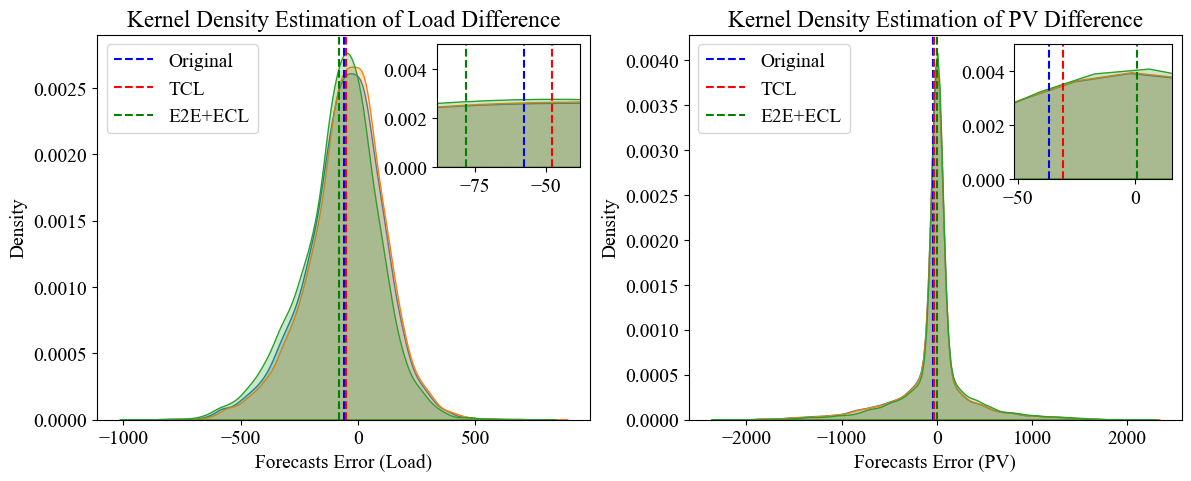

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import numpy as np

plt.rcParams.update({'font.size': 14})

# 假设 targets_load_list 和 forecasts_load_org[0.5] 以及 forecasts_load[0.5] 已经定义
# 计算差值
difference_org_load = forecasts_load_org[0.5] - targets_load
difference_load = forecasts_load[0.5] - targets_load
difference_e2e_load = forecasts_load_e2e[0.5] - targets_load
difference_e2e_ecl_load = forecasts_load_e2e_ecl[0.5] - targets_load
difference_online_e2e_load = forecasts_load_online_e2e[0.5] - targets_load

# 计算差值的均值和方差
mean_difference_org_load = np.mean(difference_org_load)
mean_difference_load = np.mean(difference_load)
mean_difference_e2e_load = np.mean(difference_e2e_load)
mean_difference_e2e_ecl_load = np.mean(difference_e2e_ecl_load)
mean_difference_online_e2e_load = np.mean(difference_online_e2e_load)

# 输出标准差
print('load')
print('Std variance_difference_org_load:', np.sqrt(np.var(difference_org_load)))
print('Std variance_difference_load:', np.sqrt(np.var(difference_load)))
print('Std variance_difference_e2e_load:', np.sqrt(np.var(difference_e2e_load)))
print('Mean_difference_org_load:', mean_difference_org_load)
print('Mean_difference_load:', mean_difference_load)
print('Mean_difference_e2e_load:', mean_difference_e2e_load)

dic = {}
dic['Load'] = [mean_difference_org_load, mean_difference_load, mean_difference_e2e_load, mean_difference_e2e_ecl_load, mean_difference_online_e2e_load]

# PV 数据
difference_org_pv = forecasts_pv_org[0.5] - targets_pv
difference_pv = forecasts_pv[0.5] - targets_pv
difference_e2e_pv = forecasts_pv_e2e[0.5] - targets_pv
difference_e2e_ecl_pv = forecasts_pv_e2e_ecl[0.5] - targets_pv
difference_online_e2e_pv = forecasts_pv_online_e2e[0.5] - targets_pv

mean_difference_org_pv = np.mean(difference_org_pv)
mean_difference_pv = np.mean(difference_pv)
mean_difference_e2e_pv = np.mean(difference_e2e_pv)
mean_difference_e2e_ecl_pv = np.mean(difference_e2e_ecl_pv)
mean_difference_online_e2e_pv = np.mean(difference_online_e2e_pv)

variance_difference_pv = np.var(difference_pv)
variance_difference_org_pv = np.var(difference_org_pv)
variance_difference_e2e_pv = np.var(difference_e2e_pv)
variance_difference_e2e_ecl_pv = np.var(difference_e2e_ecl_pv)
variance_difference_online_e2e_pv = np.var(difference_online_e2e_pv)

print('PV')
print('Std variance_difference_org_pv:', np.sqrt(variance_difference_org_pv))
print('Mean_difference_org_pv:', mean_difference_org_pv)
print('Std variance_difference_pv:', np.sqrt(variance_difference_pv))
print('Mean_difference_pv:', mean_difference_pv)
print('Std variance_difference_e2e_pv:', np.sqrt(variance_difference_e2e_pv))
print('Mean_difference_e2e_pv:', mean_difference_e2e_pv)

dic['PV'] = [mean_difference_org_pv, mean_difference_pv, mean_difference_e2e_pv, mean_difference_e2e_ecl_pv, mean_difference_online_e2e_pv]

# 创建两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 绘制 Load 图
sns.kdeplot(difference_org_load, shade=True, ax=ax1)
ax1.axvline(mean_difference_org_load, color='b', linestyle='--', label='Original')
sns.kdeplot(difference_load, shade=True, ax=ax1)
ax1.axvline(mean_difference_load, color='r', linestyle='--', label='TCL')
sns.kdeplot(difference_e2e_ecl_load, shade=True, ax=ax1)
ax1.axvline(mean_difference_e2e_ecl_load, color='g', linestyle='--', label='E2E+ECL')

ax1.set_title('Kernel Density Estimation of Load Difference')
ax1.set_xlabel('Forecasts Error (Load)')
ax1.set_ylabel('Density')
ax1.legend(loc='upper left')

x1_load = np.min([mean_difference_org_load, mean_difference_load, mean_difference_e2e_ecl_load]) - 10
x2_load = np.max([mean_difference_org_load, mean_difference_load, mean_difference_e2e_ecl_load]) + 10
y1_load, y2_load = 0, 0.005

# 添加放大子图
axins1 = inset_axes(ax1, width="29%", height="32%", loc='upper right')
axins1.set_xlim(x1_load, x2_load)
axins1.set_ylim(y1_load, y2_load)

sns.kdeplot(difference_org_load, ax=axins1, shade=True)
axins1.axvline(mean_difference_org_load, color='b', linestyle='--')
sns.kdeplot(difference_load, ax=axins1, shade=True)
axins1.axvline(mean_difference_load, color='r', linestyle='--')
sns.kdeplot(difference_e2e_ecl_load, ax=axins1, shade=True)
axins1.axvline(mean_difference_e2e_ecl_load, color='g', linestyle='--')

# 绘制 PV 图
sns.kdeplot(difference_org_pv, shade=True, ax=ax2)
ax2.axvline(mean_difference_org_pv, color='b', linestyle='--', label='Original')
sns.kdeplot(difference_pv, shade=True, ax=ax2)
ax2.axvline(mean_difference_pv, color='r', linestyle='--', label='TCL')
sns.kdeplot(difference_e2e_ecl_pv, shade=True, ax=ax2)
ax2.axvline(mean_difference_e2e_ecl_pv, color='g', linestyle='--', label='E2E+ECL')

ax2.set_title('Kernel Density Estimation of PV Difference')
ax2.set_xlabel('Forecasts Error (PV)')
ax2.set_ylabel('Density')
ax2.legend(loc='upper left')

x1_pv = np.min([mean_difference_org_pv, mean_difference_pv, mean_difference_e2e_ecl_pv]) - 15
x2_pv = np.max([mean_difference_org_pv, mean_difference_pv, mean_difference_e2e_ecl_pv]) + 15
y1_pv, y2_pv = 0, 0.005

# 添加放大子图
axins2 = inset_axes(ax2, width="32%", height="35%", loc='upper right')
axins2.set_xlim(x1_pv, x2_pv)
axins2.set_ylim(y1_pv, y2_pv)

sns.kdeplot(difference_org_pv, ax=axins2, shade=True)
axins2.axvline(mean_difference_org_pv, color='b', linestyle='--')
sns.kdeplot(difference_pv, ax=axins2, shade=True)
axins2.axvline(mean_difference_pv, color='r', linestyle='--')
sns.kdeplot(difference_e2e_ecl_pv, ax=axins2, shade=True)
axins2.axvline(mean_difference_e2e_ecl_pv, color='g', linestyle='--')
axins1.set_ylabel('')
axins2.set_ylabel('')
plt.savefig('../Figure/non parameter/difference'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.png')
plt.show()

In [46]:
if args_train.flag_dynamic_price:
    mean_result=pd.DataFrame(dic).T
    print(mean_result)
    mean_result.columns=['Original','TCL','E2E','E2E+ECL','ECL']
    mean_result.to_csv('../Result/Non parameter/Mean_difference_dynamic_price'+str(int(args_train.flag_dynamic_price))+str(args_train.flag_dynamic_mode)+'.csv')

              0          1           2          3          4
Load -57.583611 -47.725297   -3.744459 -78.400681 -83.313582
PV   -36.697311 -30.927790 -108.447981   0.816144   9.229842
